In [1]:
## For debbugging
%load_ext autoreload

In [2]:
# import os
import sys
from pathlib import Path
module_path = Path('.').resolve().parents[0]
if module_path not in sys.path:
    sys.path.append(str(module_path))


In [4]:
## for debugging:
%aimport mlp.keyword
%aimport mlp.tools
# %aimport mlp.tree
%autoreload 1
from mlp.keyword import *

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook, tqdm
%matplotlib inline

import spacy, textacy, platform
print(
    f'Textacy: \t{textacy.__version__:}'+\
    f'\nspaCy: \t{spacy.__version__:>13}'+\
    f'\nPython: \t{platform.python_version()}'
    )

Textacy: 	0.3.4
spaCy: 	        1.9.0
Python: 	3.6.3


In [64]:
import dask.dataframe as dd
import dask
import string

# nlp = spacy.load('en')
# data_dir = module_path/'data'/'mine_data'
# df = dd.read_csv(data_dir/'loader_work_orders_sanitised.csv')
data_dir = module_path/'data'/'gs_data'
df = dd.read_csv(data_dir/'Maintenance_All_Clean.csv')

FileNotFoundError: [WinError 2] The system cannot find the file specified: 'E:\\Thurston\\Documents\\Code\\Pycharm\\ml-py\\data\\mine_data\\loader_work_orders_sanitised.csv'

In [65]:
raw_text = df.Description.astype(str) + '. ' + df.Resolution.astype(str)
# raw_text = df.ShortText.astype(str)
raw_text = raw_text.fillna('')
raw_text = raw_text.str.lower()
raw_text.str.replace('\n', ' ')
raw_text = raw_text.str.replace('[{}]'.format(string.punctuation), '')

# def text_preproc(doc, **preproc_kws):
# #     x = textacy.preprocess.normalize_whitespace(x)
# #     x = textacy.preprocess.preprocess_text(x, **preproc_kws)
# #     doc = nlp(x)
#     proc_list = [token.lemma_ for token in doc
#                    if not (punct_space(token) or token.is_stop)]
#     proc_doc = ' '.join(proc_list)
#     if len(proc_doc) <= 1:
#         proc_doc = 'NaN'
#     return proc_doc

def series_itervals(s):
    for n, val in s.iteritems():
        yield val
# for doc in tqdm(nlp.pipe(series_itervals(raw_text))):
#     new_doc = text_preproc(doc)
# raw_text = raw_text.apply(textacy.preprocess.normalize_whitespace, meta=('RawText', str))
# preproc_kws = {
#     'fix_unicode': True, 
#     'lowercase': True,
#     'no_urls': True,
#     'no_emails': True,
#     'no_phone_numbers': True,
#     'no_punct': True,
#     'no_contractions': True,
#     'no_accents': True
# }
# raw_text = raw_text.apply(textacy.preprocess.preprocess_text, meta=raw_text, **preproc_kws)
# raw_text = raw_text.apply(text_preproc, meta=raw_text, **preproc_kws)
# tqdm.pandas(desc="KEx")
# raw_text = raw_text.progress_apply(text_preproc)

# df['RawText'] = raw_text

# with dask.set_options(get=dask.multiprocessing.get):
# raw_text.to_csv(data_dir/'TEMP_init-*.txt', index=False)


# with dask.set_options(get=dask.multiprocessing.get):
#     rt = raw_text.compute()
# rt

In [66]:
from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer(input='content', 
                      ngram_range=(2,3),
                      stop_words='english',
#                       min_df=2, 
#                       max_df=0.95,
                      sublinear_tf=True,
                      smooth_idf=False,
                      max_features=400
                     )

vec.fit(series_itervals(raw_text))

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=400, min_df=1,
        ngram_range=(2, 3), norm='l2', preprocessor=None, smooth_idf=False,
        stop_words='english', strip_accents=None, sublinear_tf=True,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [67]:
vec.transform(series_itervals(raw_text)).toarray().shape

(3435, 400)

[('chip conveyor', 4.5466523545218598),
 ('accumulator check', 4.5878953130559088),
 ('inop replaced', 4.6199836276074091),
 ('hydraulic leak', 4.6419625343261846),
 ('check requested', 4.7597455699825684),
 ('accumulator check requested', 4.8513127635080586),
 ('brush unit', 4.879092327615135),
 ('operator level', 4.9521174626300244),
 ('brushing unit', 5.0642347607507299),
 ('charged 30bar', 5.1714802911043281),
 ('bar loader', 5.2297491992283041),
 ('coolant pump', 5.2916246029463911),
 ('broken replaced', 5.33510971488613),
 ('faults replaced', 5.33510971488613),
 ('spindle bearings', 5.3575825707381881),
 ('replaced broken', 5.3575825707381881),
 ('removed replaced', 5.3575825707381881),
 ('replaced motor', 5.4528927505425138),
 ('drill detector', 5.5864241431670356),
 ('check charge', 5.5864241431670356),
 ('table index', 5.615411680040288),
 ('conveyor jammed', 5.615411680040288),
 ('bearings replaced', 5.615411680040288),
 ('power pack', 5.6452646431899698),
 ('sensor cable', 5

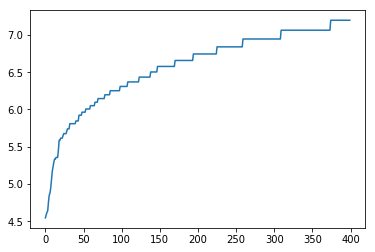

In [62]:
sort = vec.idf_.argsort()
# sort
# np.array(vec.get_feature_names())[sort]
plt.plot(vec.idf_[sort])
list(zip(np.array(vec.get_feature_names())[sort], vec.idf_[sort]))


In [50]:
sort

array([216,  37, 285, 136, 210, 243, 169, 147,  23, 214, 289,  53, 139,
       164, 131,  80, 173, 171,   5,  10, 109,  77, 181, 233,  29,  14,
       267, 160, 197, 200, 187,  57, 221, 220, 229, 149,  64, 268, 156,
        72, 142, 195,  51, 101,  26,  44, 108, 276,   2, 206,  20,  58,
       177, 122, 178,  12,   6, 133,  75, 297, 137, 266, 132,  67, 127,
       111,  32,  36,  61, 228, 161,  55, 150, 198,  19, 154,  46, 249,
        68, 284,  40,  71, 115,  41, 117, 145, 272, 194, 141, 124, 263,
       182,  99, 134, 105,  42, 129, 165, 172, 215, 157, 167,  43, 291,
        73, 119, 294,  15, 185,  74, 219, 262, 162, 236,  52,  93, 235,
       225, 293, 118,  25, 222, 116,  90, 281, 179,   7, 183, 261, 106,
       163,  83,  92, 240, 155,  39,  49, 193, 110,  98,  95, 205,  48,
       244, 212, 217, 112,   4,  59, 226, 176, 144, 242, 278, 241,  65,
       126, 135, 120, 218, 279, 232, 213,  18,  56,  89, 168, 190,  69,
       175,  33, 258, 250,  28, 253, 246, 247, 252, 248, 138, 19

In [11]:
for fname in data_dir.glob('TEMP_init-*.txt'):
    print(fname)

E:\Thurston\Documents\Code\Pycharm\ml-py\data\gs_data\TEMP_init-0.txt


In [129]:
# docs = textacy.fileio.read.read_csv(str(data_dir/'TEMP_init-0.txt'))
# Descriptions in RawText col
# content_stream, metadata_stream = textacy.fileio.split_record_fields(docs, 1)  

corpus = textacy.Corpus(u'en')

for fname in data_dir.glob('TEMP_init-*.txt'):
    print(fname)
    docs = textacy.fileio.read.read_csv(str(fname), delimiter='\t')
    content_stream, _ = textacy.fileio.split_record_fields(docs, 0)  
    corpus.add_texts(content_stream)

/home/tbsexton/Documents/Projects/DiagnosticKB/MaintenanceLanguageProcessing/data/gs_data/TEMP_init-0.txt


In [144]:
vsm = textacy.vsm.Vectorizer(weighting='tfidf',
                             normalize=False,
                             smooth_idf=False,
                             sublinear_tf=True,
                             min_df=2, max_df=0.95)  # each token in >2 docs, <95% of docs

terms_list = (doc.to_terms_list(ngrams=(1, 2, 3),
                                normalize=u'lemma',
                                named_entities=False,
                                filter_stops=True,  # Nope! Not needed :)
                                filter_punct=True,
                                as_strings=True) for doc in corpus)
doc_term_mat = vsm.fit_transform(terms_list)
doc_term_mat

def get_norm_tokens(doc_n, doc_term_mat, id_to_term):
    doc = doc_term_mat[doc_n].toarray()
    # we only care about unique tags, right?
    return set([id_to_term[i] for i in doc.nonzero()[1]])

# list(list(terms_list)[1])

In [145]:
get_norm_tokens(0, doc_term_mat, vsm.id_to_term)

{'bar',
 'bar feeder',
 'bar feeder chain',
 'break',
 'break bar',
 'break bar feeder',
 'chain',
 'feeder',
 'feeder chain',
 'repair'}

In [ ]:
vsm.sublinear_tf()